# Introduction

This document demonstrates how to build and train a simple neural network using PyTorch for binary classification on a synthetic spiral dataset. We integrate Weights & Biases (wandb) to record training metrics (F1 score, recall, precision) along with the network’s weights, biases, and gradients during training. A random sweep is conducted over four hyperparameters—hidden units per layer, learning rate, dropout percentage, and batch size—with four candidate values each. Out of all possible combinations, 12 random samples will be chosen for the sweep. In addition, this notebook is updated to run on CUDA (GPU) if available, or on the CPU otherwise.

# 1. Importing Libraries and Setting the Device

We begin by importing libraries for numerical computations, plotting, neural network modeling with PyTorch, evaluation metrics, and wandb for experiment tracking. We then set the device based on CUDA availability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split,Subset
from torchvision import datasets, transforms
import torchmetrics
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch.nn.init as init
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import os
import wandb

# Set device to GPU if available, otherwise CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")


# Set a global seed value
seed = 42

# For NumPy
np.random.seed(seed)

# For PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


In [2]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_percentage=0.4):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(dropout_percentage)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):

        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(self.leaky_relu(self.bn4(self.conv4(x))))
        x = self.leaky_relu(self.bn5(self.conv5(x)))

        x = torch.flatten(x, start_dim=1)

        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [4]:
def initialize_weights(model, method=None,constant_value = 0.1): 
    if method is None:
        print("No initialization required")
        return  

    for name, param in model.named_parameters():
        if 'weight' in name:
            if method == 'he_uniform':
                init.kaiming_uniform_(param, nonlinearity='relu')
            elif method == 'constant':
                init.constant_(param, constant_value)
            else:
                raise ValueError(f"Unsupported initialization method: {method}")
        elif 'bias' in name:
            init.constant_(param, 0.0)  # Initialize biases to 0

In [5]:
# Initialize wandb. The hyperparameters will be updated by the sweep.
wandb.login(key="9ab13478cceef58f66f93a6be9e5f1e7a1f7e3d4")  
wandb.init(project="Assignment4", entity="usf-magma", config={
    "num_classes": 10,        # default, will be overridden
    "learning_rate": 0.0005,      # default, will be overridden
    "dropout_percentage": 0.4,  # default, will be overridden
    "batch_size": 64,           # default, will be overridden
    "epochs": 20,
    "momentum":(0.9, 0.92),
    "weight_decay": 1e-4 ,
    "initialize_weights": "constant"
})
wandb.run.name = "bermudezm"
wandb.run.save()
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maurb\_netrc
wandb: Currently logged in as: bermudezm (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## 4.2 Prepare DataLoader

We create a DataLoader for training using the batch size from the configuration.

In [6]:
# Define transformations
image_size = (256, 256)  # Change this to your required size
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Define root directory
root_dir = "./art"

# Function to limit dataset size per class
def limit_dataset(dataset, max_per_class=3000):
    class_indices = {class_idx: [] for class_idx in range(len(dataset.classes))}
    
    # Organize indices by class
    for idx, class_idx in enumerate(dataset.targets):  
        class_indices[class_idx].append(idx)
    
    # Sample up to max_per_class images per class
    limited_indices = []
    for class_idx, indices in class_indices.items():
        limited_indices.extend(random.sample(indices, min(len(indices), max_per_class)))
    
    return Subset(dataset, limited_indices)

# Load and limit training dataset
train_dataset = datasets.ImageFolder(root=f"{root_dir}/train", transform=transform)
train_dataset = limit_dataset(train_dataset, max_per_class=3000)

# Load and limit testing dataset
val_dataset = datasets.ImageFolder(root=f"{root_dir}/test", transform=transform)
val_dataset = limit_dataset(val_dataset, max_per_class=700)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

In [7]:
# Instantiate the model with the hyperparameters.
model = CNN( num_classes=config.num_classes, dropout_percentage=config.dropout_percentage)
model = model.to(device)  # Move the model to the appropriate device.
#initialize_weights(model, method=config.initialize_weights,constant_value = 0.1) 
optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=config.learning_rate, 
            betas=config.momentum, 
            weight_decay=config.weight_decay
        )
# Setup the optimizer with the specified learning rate.
criterion = nn.CrossEntropyLoss()
wandb.watch(model, log="all", log_freq=120)
# Log gradients and parameters to wandb.



Total iterations: 9380
Logging will happen 78 times.
Epoch now is : 0
Epoch 0: Train Loss = 2.0036, Val Loss = 1.8704, F1 Train = 0.2531, F1 Val = 0.2826, Precision Train = 0.2475, Precision Val = 0.3013, Recall Train = 0.2689, Recall Val = 0.3147


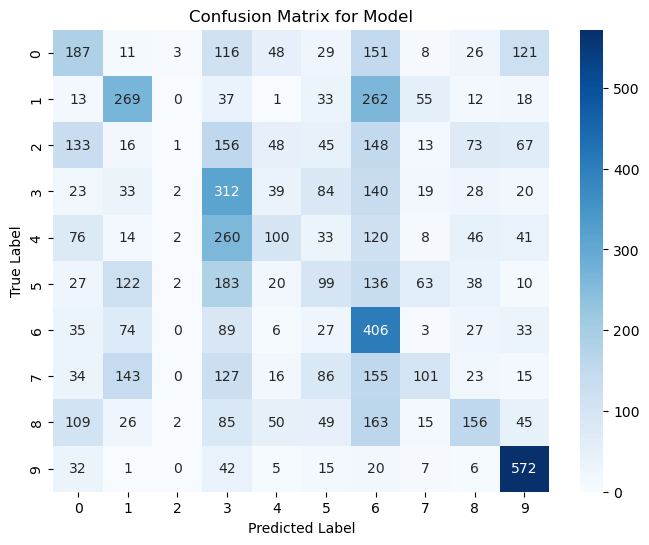

Epoch now is : 1
Epoch now is : 2
Epoch 2: Train Loss = 1.7162, Val Loss = 1.7181, F1 Train = 0.3630, F1 Val = 0.3342, Precision Train = 0.3575, Precision Val = 0.3470, Recall Train = 0.3770, Recall Val = 0.3737


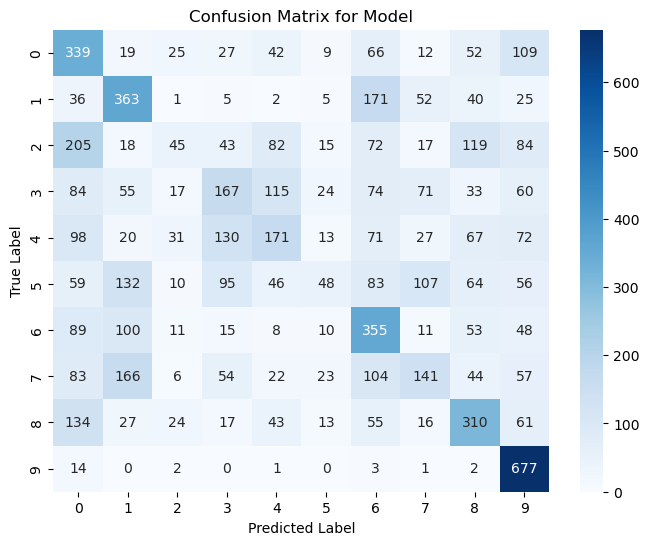

Epoch now is : 3
Epoch now is : 4
Epoch 4: Train Loss = 1.5899, Val Loss = 1.9437, F1 Train = 0.4075, F1 Val = 0.3238, Precision Train = 0.4037, Precision Val = 0.3905, Recall Train = 0.4202, Recall Val = 0.3453


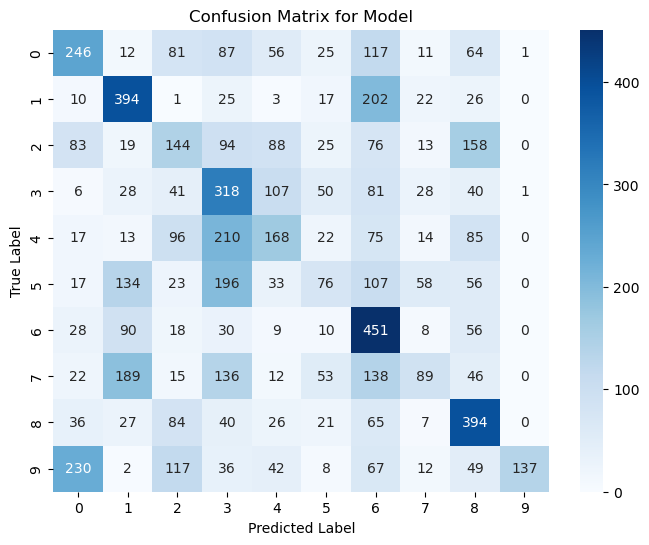

Epoch now is : 5
Epoch now is : 6
Epoch 6: Train Loss = 1.4771, Val Loss = 1.6682, F1 Train = 0.4526, F1 Val = 0.3832, Precision Train = 0.4488, Precision Val = 0.3913, Recall Train = 0.4615, Recall Val = 0.4074


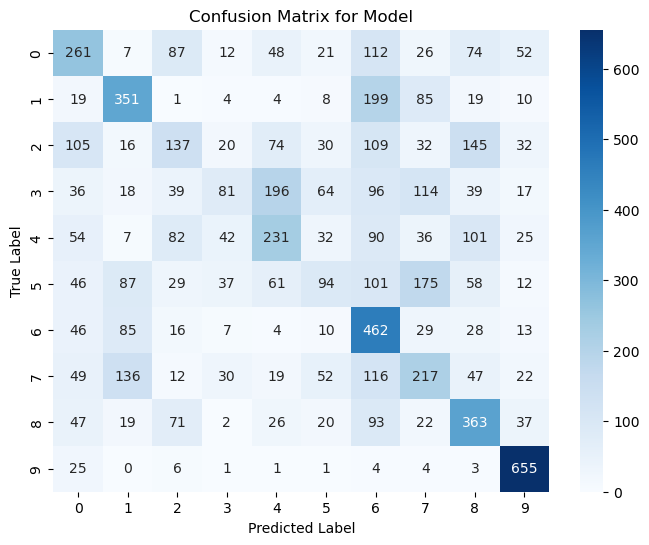

Epoch now is : 7
Epoch now is : 8
Epoch 8: Train Loss = 1.3544, Val Loss = 1.5713, F1 Train = 0.5003, F1 Val = 0.4295, Precision Train = 0.4976, Precision Val = 0.4384, Recall Train = 0.5060, Recall Val = 0.4321


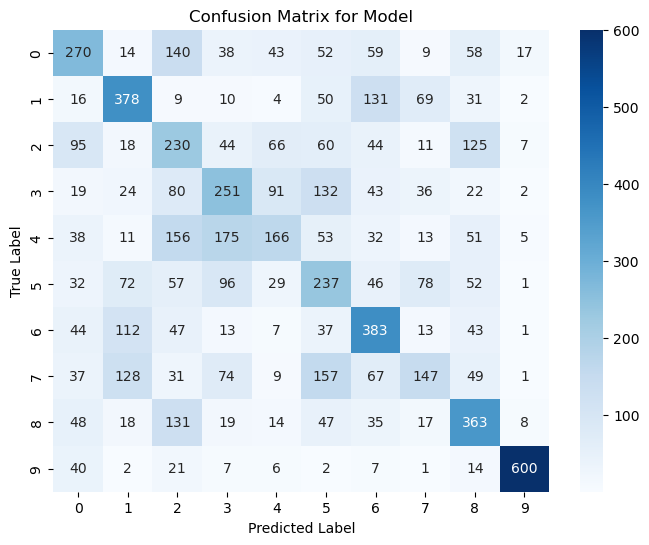

Epoch now is : 9
Epoch now is : 10
Epoch 10: Train Loss = 1.1860, Val Loss = 1.8795, F1 Train = 0.5587, F1 Val = 0.3863, Precision Train = 0.5574, Precision Val = 0.3978, Recall Train = 0.5619, Recall Val = 0.3987


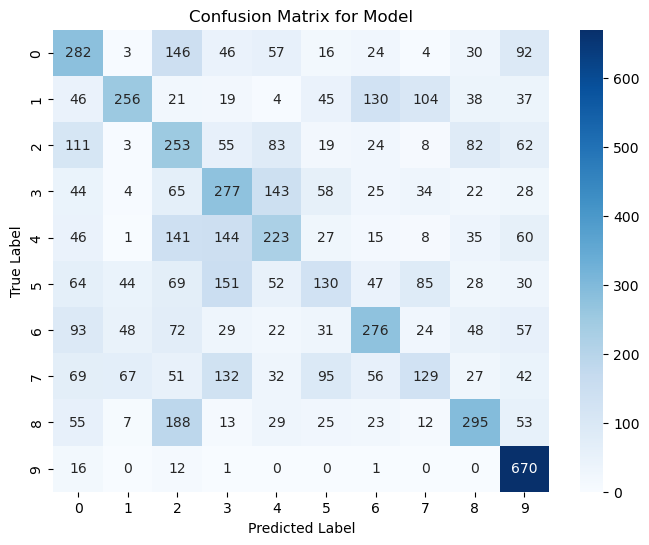

Epoch now is : 11
Epoch now is : 12
Epoch 12: Train Loss = 0.9947, Val Loss = 1.7822, F1 Train = 0.6296, F1 Val = 0.4213, Precision Train = 0.6294, Precision Val = 0.4298, Recall Train = 0.6309, Recall Val = 0.4294


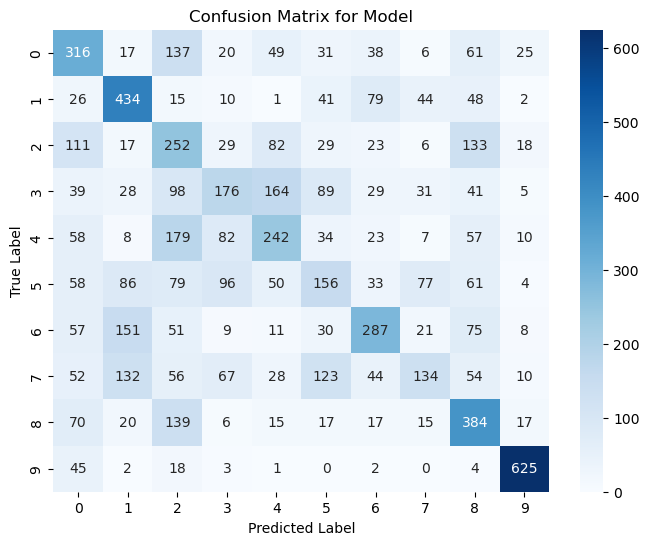

Epoch now is : 13
Epoch now is : 14
Epoch 14: Train Loss = 0.7933, Val Loss = 2.2438, F1 Train = 0.7052, F1 Val = 0.3893, Precision Train = 0.7059, Precision Val = 0.4056, Recall Train = 0.7054, Recall Val = 0.3947


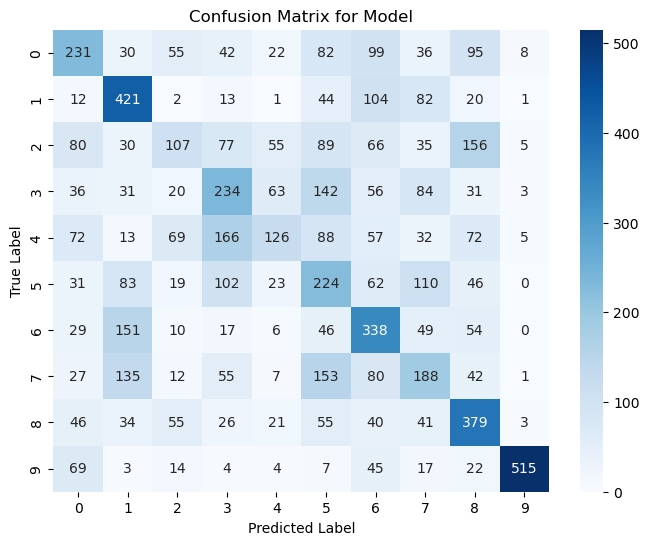

Epoch now is : 15
Epoch now is : 16
Epoch 16: Train Loss = 0.6154, Val Loss = 2.5428, F1 Train = 0.7745, F1 Val = 0.4004, Precision Train = 0.7752, Precision Val = 0.4264, Recall Train = 0.7747, Recall Val = 0.3947


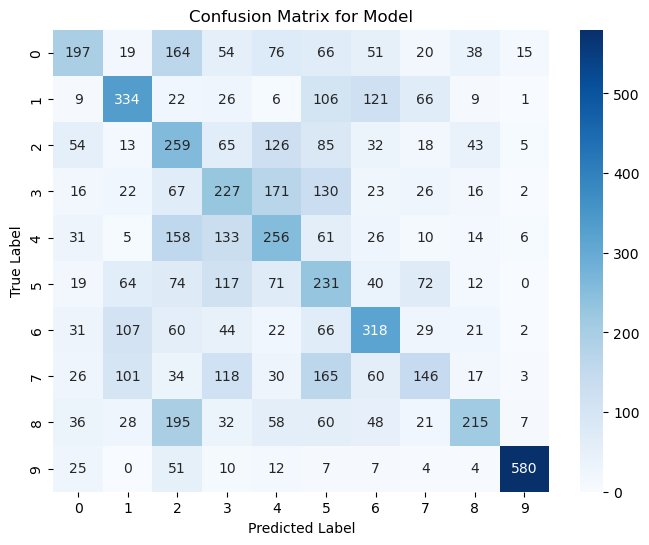

Epoch now is : 17
Epoch now is : 18
Epoch 18: Train Loss = 0.4831, Val Loss = 2.5483, F1 Train = 0.8296, F1 Val = 0.3891, Precision Train = 0.8302, Precision Val = 0.3999, Recall Train = 0.8296, Recall Val = 0.3917


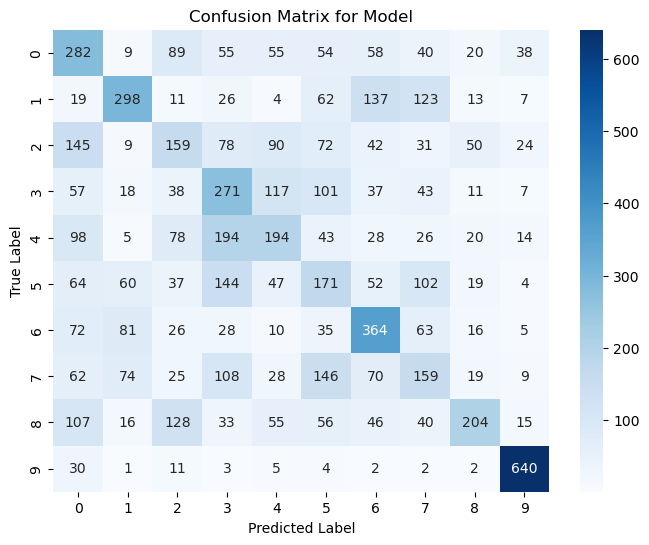

Epoch now is : 19


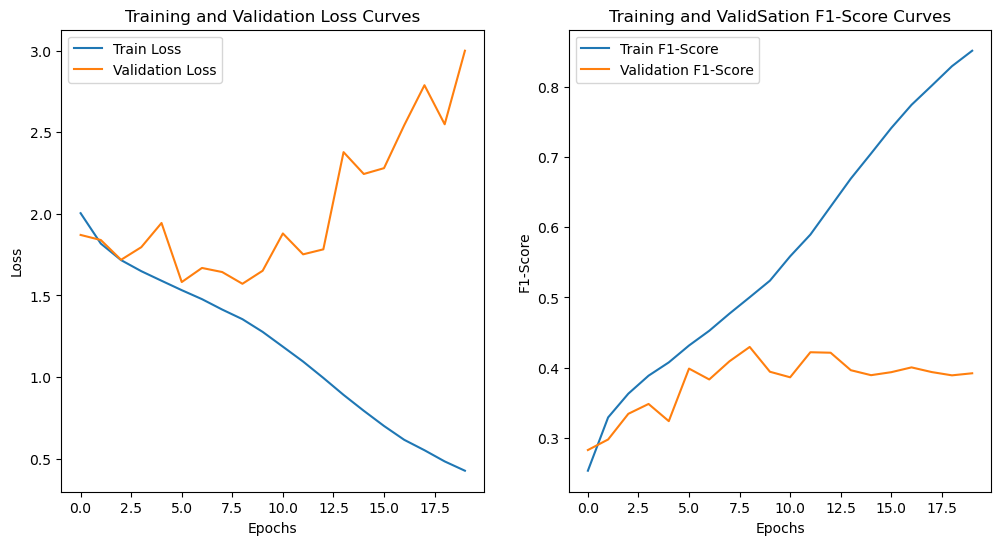

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_train,▁▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_val,▁▂▃▄▃▇▆▇█▆▆██▆▆▆▇▆▆▆
precision_train,▁▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
precision_val,▁▃▃▆▅▆▅▆█▆▆█▇▇▆▆▇▆▆▇
recall_train,▁▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
recall_val,▁▁▅▄▃▇▇██▇▆▇█▆▆▆▆▆▆▅
train_loss,█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
val_loss,▂▂▂▂▃▁▁▁▁▁▃▂▂▅▄▄▆▇▆█
epoch,19
f1_train,0.8517


In [8]:
num_epochs = config.epochs
train_losses, val_losses = [], []
f1_train_scores, f1_val_scores = [], []
precision_train_scores, precision_val_scores = [], []
recall_train_scores, recall_val_scores = [], []
# Calculate total iterations and log frequency count
total_batches_per_epoch = len(train_loader)
total_iterations = total_batches_per_epoch * num_epochs
num_log_calls = total_iterations // 120

print(f"Total iterations: {total_iterations}")
print(f"Logging will happen {num_log_calls} times.")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_train_preds, all_train_labels = [], []
    print(f"Epoch now is : {epoch}")
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        all_train_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_train_labels.append(batch_y.cpu().numpy())
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    f1_train = f1_score(all_train_labels, all_train_preds, average='weighted')
    precision_train = precision_score(all_train_labels, all_train_preds, average='weighted')
    recall_train = recall_score(all_train_labels, all_train_preds, average='weighted')
    
    f1_train_scores.append(f1_train)
    precision_train_scores.append(precision_train)
    recall_train_scores.append(recall_train)
    
    # Evaluación en el conjunto de validación
    model.eval()
    val_loss = 0.0
    all_val_preds, all_val_labels = [], []
    
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            
            val_logits = model(batch_X_val)
            loss = criterion(val_logits, batch_y_val)
            val_loss += loss.item()
            
            all_val_preds.append(val_logits.argmax(dim=1).cpu().numpy())
            all_val_labels.append(batch_y_val.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    f1_val = f1_score(all_val_labels, all_val_preds, average='weighted')
    precision_val = precision_score(all_val_labels, all_val_preds, average='weighted')
    recall_val = recall_score(all_val_labels, all_val_preds, average='weighted')
    
    f1_val_scores.append(f1_val)
    precision_val_scores.append(precision_val)
    recall_val_scores.append(recall_val)
    cm = confusion_matrix(all_val_labels, all_val_preds)
    
    wandb.log({
        "epoch": epoch,
        "train_loss": epoch_loss,
        "val_loss": val_loss,
        "f1_train": f1_train,
        "f1_val": f1_val,
        "precision_train": precision_train,
        "precision_val": precision_val,
        "recall_train": recall_train,
        "recall_val": recall_val,
        "confusion_matrix": cm
    })
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"F1 Train = {f1_train:.4f}, F1 Val = {f1_val:.4f}, "
              f"Precision Train = {precision_train:.4f}, Precision Val = {precision_val:.4f}, "
              f"Recall Train = {recall_train:.4f}, Recall Val = {recall_val:.4f}")
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix for Model')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(f1_train_scores, label='Train F1-Score')
plt.plot(f1_val_scores, label='Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Training and ValidSation F1-Score Curves')
plt.legend()

plt.show()
wandb.finish()

